BRIEF > Le directeur d'une grande chaîne de magasins fait appel à vos services pour que vous aidiez l'équipe marketing à déterminer la stratégie commerciale la meilleure. Pour ce faire, vous devez réaliser une segmentation de la clientèle , c'est à dire identifier les catégories de clients les plus à même de consommer, et comprendre leur comportements d'achats. Vous disposez d'une base de données des clients abonnés avec des informations basiques telles que :  le numéro client, l'âge, le sexe, le revenu annuel et le score de dépenses (indice de consommation de 1-100.

I.IMPORTATION des librairies

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import scikitplot as skplt
from sklearn import metrics
import seaborn as sns
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from matplotlib import colors
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

II.CHARGEMENT d'un dataset

In [2]:
#CHARGEMENT d'un dataset et création du dataframe

#en URL

url = 'https://simplonline-v3-prod.s3.eu-west-3.amazonaws.com/media/file/csv/6b1ca02d-1c66-4783-b237-8fe0c2dea791.csv'
df = pd.read_csv(url, index_col=0, encoding = "ISO-8859-1")

IV.EXPLORATION

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


A priori je n'ai pas de valeurs nulles et j'ai une seule classe en object qui est le genre. Il faudra encoder.
J'aimerais aussi savoir par la suite si j'ai des valeurs aberrantes.

Spending Score: It is the score(out of 100) given to a customer by the mall authorities, based on the money spent and the behavior of the customer (source: https://towardsdatascience.com/mall-customers-segmentation-using-machine-learning-274ddf5575d5). Plus le score est élevé, plus le client est susceptible de dépenser.

In [4]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [5]:
# La fonction .describe() nous donne une vision d'ensemble (statistiques) pour chaque colonne
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


count: compte le nombre de valeurs non nulles dans le dataset. 
mean: valeur moyenne.
std: 'standard deviation', écart type, indicateur statistique mesurant la dispersion des valeurs d'un échantillon autour de la moyenne.
min: valeur minimum.
25%: premier quartile 1/4( ou centile 25%) représente 25% des valeurs de l'échantillon. 
50%: La médiane est la valeur centrale d'une série statistique dont les valeurs observées ont été ordonnées.
75%: troisième quartile 3/4 (ou centile 75%) représente 75% des valeurs de l'échantillon.
max: valeur maximum.

L'âge minimum et maximum me montrent que je n'ai pas de valeur aberrante concernant l'âge. 
Idem pour les autres colonnes.
L'âge minimum à 18 ans me semble ignorer la tranche d'âge adolescente de moins de 18 ans qui représente pourtant un pouvoir d'achat. 

In [6]:
#Avant d'encoder le genre je vérifie le nombre de valeurs uniques

df['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

Les hommes sont moins représentés que les femmes.

In [7]:
#J'encode le genre avec getdummies pour obtenir un encodage binaire qui corresponde aux deux valeurs trouvées ci-dessus

df = pd.get_dummies(df, columns = ['Gender'], prefix = ['Gender'])





In [8]:
#Je vérifie que cela ait fonctionné
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,0,1
2,21,15,81,0,1
3,20,16,6,1,0
4,23,16,77,1,0
5,31,17,40,1,0


Maintenant que l'encodage est fait, je peux visualiser les corrélations entre mes variables

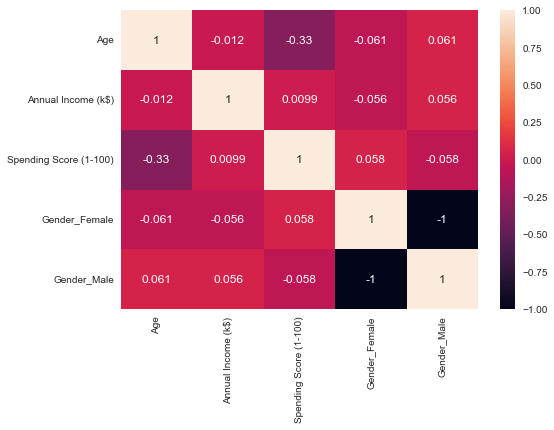

In [9]:
#Faire une matrice de corrélation et heatmap
##Pour lire la matrice on considère que les extrêmes -1 et 1 sont les plus proches d'une corrélation

from seaborn import heatmap
correlation_mat = df.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()


Il n'y a pas de corrélation qui ressorte particulièrement, sauf entre l'âge et le spending score.

IX.VISUALISATION DES DONNEES (et non pas du modèle)

No handles with labels found to put in legend.


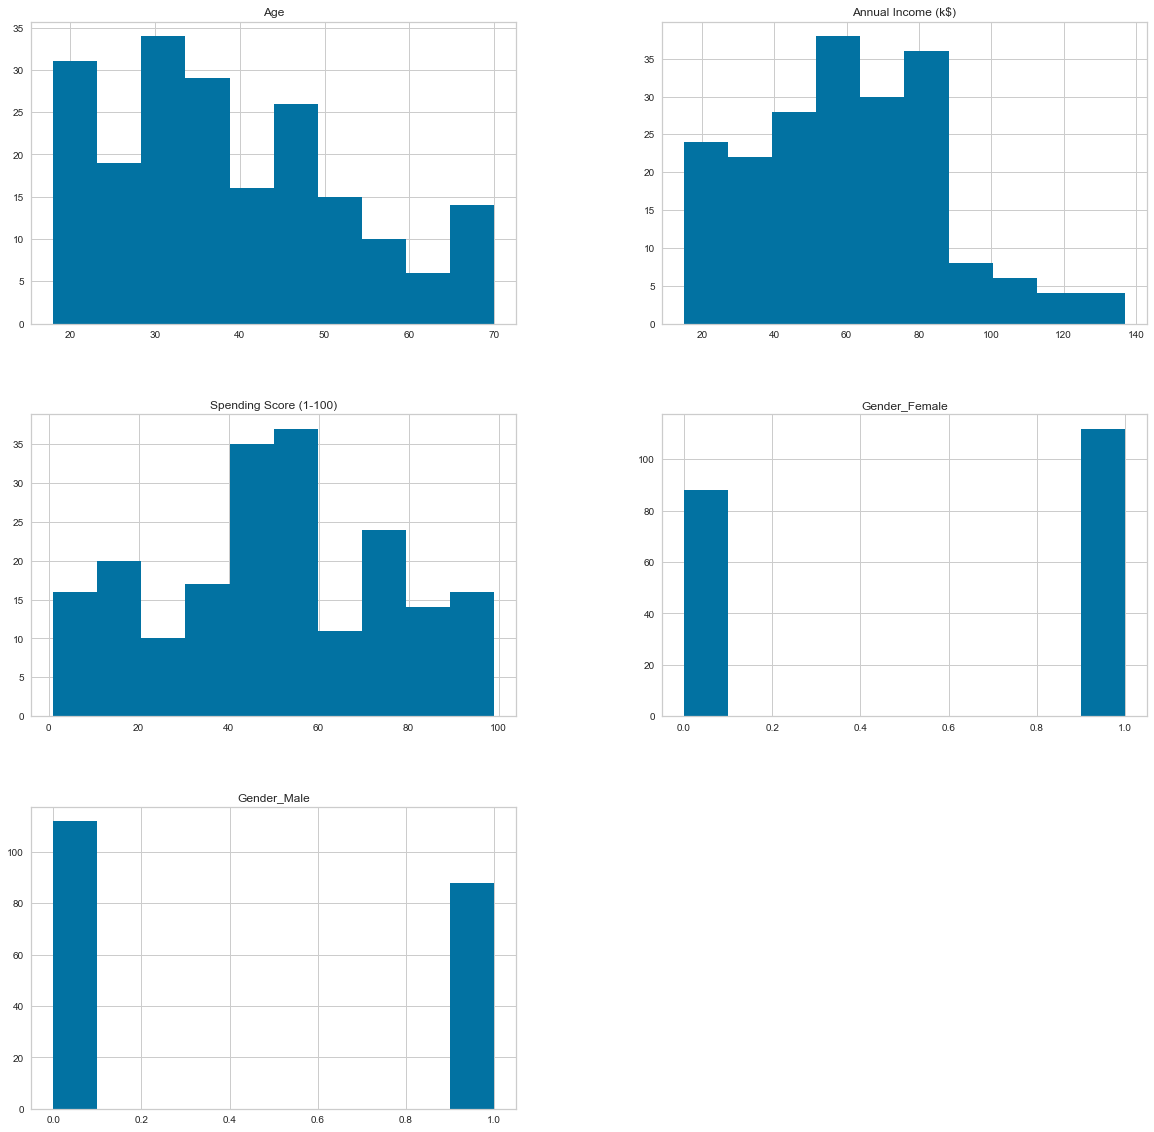

In [10]:
#tous les histo d'un coup
df.hist(figsize=(20,20))
plt.legend()
plt.show()

XI.CLUSTERING

J'utilise l'elbow method pour déterminer le nombre de cluster qui peuvent être formés

Elbow Method to determine the number of clusters to be formed:


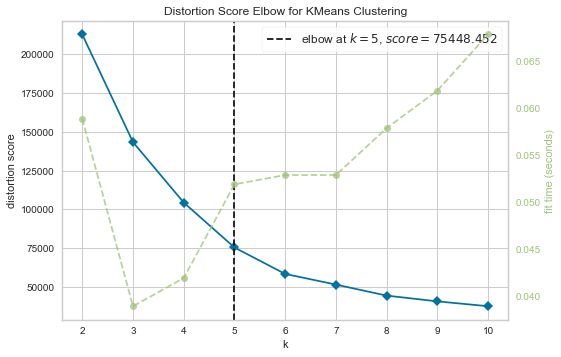

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df)
Elbow_M.show()

5 sera un nombre optimal de clusters.

XII.CREATION du modèle

J'initialise et j'entraîne le modèle

In [12]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat_AC = AC.fit_predict(df)
df["Clusters"] = yhat_AC


EVALUATION

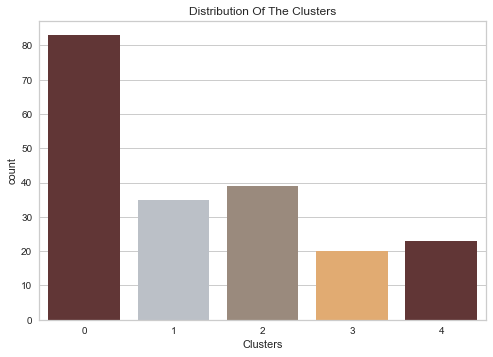

In [13]:
#Je veux voir la distribution de mes clusters

pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60","#682F2F"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

Les clusters semblent assez mal distribués.

PROFILAGE

In [15]:
#Je vais déterminer quels sont les traits de chaque groupe de consommateurs

#Avant cela, je veux connaître les valeurs moyennes de chaque cluster

avg_df = df.groupby(['Clusters'], as_index=False).mean()
avg_df

,Clusters,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,0,42.156627,54.759036,49.771084,0.602410,0.397590
1,1,41.685714,88.228571,17.285714,0.428571,0.571429
2,2,32.692308,86.538462,82.128205,0.538462,0.461538
3,3,24.850000,24.950000,81.000000,0.600000,0.400000
4,4,45.217391,26.304348,20.913043,0.608696,0.391304


<AxesSubplot:xlabel='Clusters', ylabel='Age'>

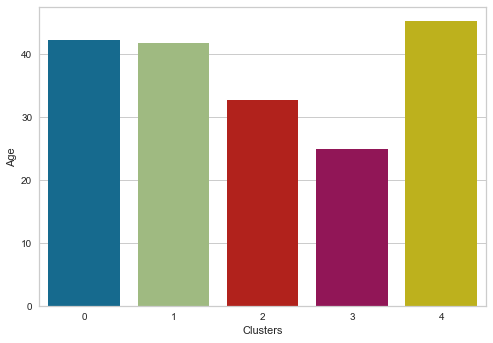

In [16]:
#Ainsi que la visualisation pour chaque cluster concernant l'âge
sns.barplot(x='Clusters',y='Age',data=avg_df)


<AxesSubplot:xlabel='Clusters', ylabel='Spending Score (1-100)'>

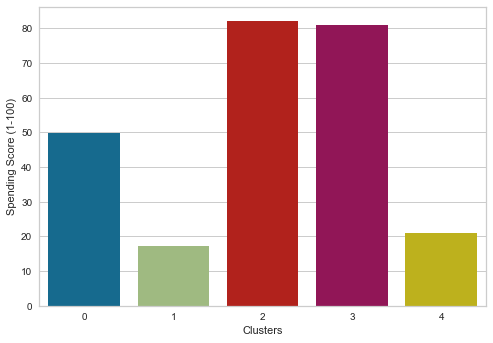

In [17]:
#Le spending score
sns.barplot(x='Clusters',y='Spending Score (1-100)',data=avg_df)


<AxesSubplot:xlabel='Clusters', ylabel='Annual Income (k$)'>

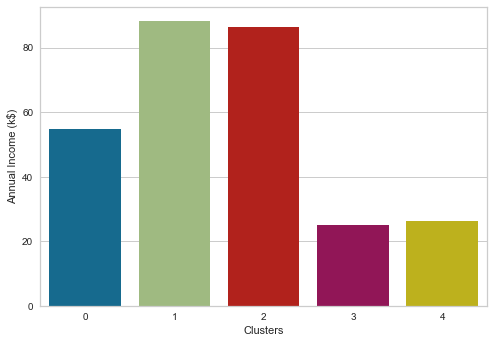

In [21]:
#Et l'annual income
sns.barplot(x='Clusters',y='Annual Income (k$)',data=avg_df)

>Description des clusters

Cluster 0: 
*revenu annuel autour de 50K
*spending score moyen de 50
*âge autour de 40 ans
*représentation nettement plus féminine

Cluster 1:
*revenu annuel le plus élevé autour de 90K
*spending score le plus bas en dessous de 20
*âge autour de 40 ans, sensiblement plus âgé que le cluster 0
*une représentation plus masculine que féminine

Cluster 2:
*revenu annuel le second plus élevé,autour de 86K
*spending score le plus élevé
*âge autour de 30 ans
*plus de femmes que d'hommes mais c'est le cluster le plus équilibré en terme de représentation de genre

Cluster 3:
*tranche la plus jeune, autour de 20 ans
*spending score le second plus élevé
*revenu annuel le plus faible, autour de 20K
*large représentation féminine

Cluster 4:
*tranche d'âge la plus élevée, autour de 45 ans
*des revenus presque aussi faibles que ceux de la tranche d'âge la plus jeune
*spending score faible de 20
*femmes beaucoup plus représentées que les hommes

>Analyse

Les catégories de clients qui ressortent peuvent être les suivantes:

1)Les jeunes dépensiers
Une catégorie aux faibles revenus car sûrement inactive ou ayant un premier emploi peu rémunéré. Une représentation largement féminine et représentant une grande quantité des dépenses. Le mall est un lieu d'identification et de rencontre pour cette tranche là, qui répond à ses besoins en terme de produits.

2)Les trentenaires actifs
La catégorie la moins déséquilibrée en terme de représentation de genre et avec de forts revenus. On suppose que ce sont des personnes ayant un emploi bien rémunéré, avec peu de personnes à charge et qui peuvent se permettre de dépenser.

3)Les quarantenaires aisés qui dépensent peu
Une catégorie plus masculine que féminine, qui apparemment ne considère pas le mall comme le lieu priviligié où trouver les produits qui lui correspondent.

4)Les quarantenaires de classe moyenne
Une catégorie féminine qui dépense souvent au mall. 

>Conclusions

La tranche d'âge en dessous de 20 ans et au-dessus de 45 ans est peu représentée. On suppose que les données des mineurs n'ont pas été enregistrées, ce qui peut fausser l'analyse. Par contre il est évident que les seniors se rendent beaucoup moins au mall pour leurs achats. Les produits peuvent ne pas leur correspondre, ni les services d'accompagnement à l'achat. Les données ne nous permettent pas d'envisager leurs capacités de dépense et si un effort commercial est à faire en leur direction.

La catégorie 3, possédant le plus de capacités de dépense, pourraît être attirée par des produits plus haut-de-gamme.

Les jeunes dépensiers et les trentenaires actifs sont des cibles à privilégier.






